<a href="https://colab.research.google.com/github/thedavidemmanuel/model-training-and-evaluation/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

In [4]:
# Load dataset
true_news_path = '/content/drive/My Drive/Fake_News_Classification/data/True.csv'
fake_news_path = '/content/drive/My Drive/Fake_News_Classification/data/Fake.csv'

true_news = pd.read_csv(true_news_path)
fake_news = pd.read_csv(fake_news_path)

# Add labels
true_news['label'] = 1
fake_news['label'] = 0

# Combine datasets
df = pd.concat([true_news, fake_news], ignore_index=True)

In [5]:
# Preprocess Data
print("Columns in DataFrame:", df.columns)

# Handle missing values in 'text' column if it exists
if 'text' in df.columns:
    df = df.dropna(subset=['text'])
else:
    print("Column 'text' not found in DataFrame.")

# Clean and Parse the Date Strings
def parse_date(date_string):
    date_string = date_string.strip()  # Remove leading and trailing spaces
    try:
        return datetime.strptime(date_string, "%B %d, %Y")
    except ValueError:
        return pd.NaT  # Return NaT (Not a Time) for invalid date formats

# Apply the function to your DataFrame
df['date'] = df['date'].apply(parse_date)

# Extract additional features from date
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_month'] = df['date'].dt.day


Columns in DataFrame: Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


In [6]:
# Feature engineering
df['text_length'] = df['text'].str.len()
df['title_length'] = df['title'].str.len()

# Shuffle the data
df = df.sample(frac=1, random_state=42)

# Combine title and text, giving more weight to the title
df['content'] = df['title'] + ' ' + df['title'] + ' ' + df['text']

In [7]:
# Split the data
X = df[['content', 'subject', 'text_length', 'title_length', 'day_of_week', 'month']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['content'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['content'])

# Save vectorizer
import pickle
with open('/content/drive/My Drive/Fake_News_Classification/saved_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [8]:
# Define simple model
def create_simple_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

simple_news_model = create_simple_model(X_train_tfidf.shape[1])

In [9]:
# Train simple model
simple_history = simple_news_model.fit(
    X_train_tfidf.toarray(), y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    verbose=1
)

Epoch 1/10
898/898 [==============================] - 7s 5ms/step - loss: 0.0811 - accuracy: 0.9771 - val_loss: 0.0312 - val_accuracy: 0.9907
Epoch 2/10
898/898 [==============================] - 6s 6ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.0303 - val_accuracy: 0.9912
Epoch 3/10
898/898 [==============================] - 4s 4ms/step - loss: 8.1504e-04 - accuracy: 0.9999 - val_loss: 0.0346 - val_accuracy: 0.9911
Epoch 4/10
898/898 [==============================] - 4s 4ms/step - loss: 2.7591e-04 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 0.9923
Epoch 5/10
898/898 [==============================] - 5s 5ms/step - loss: 6.6122e-05 - accuracy: 1.0000 - val_loss: 0.0346 - val_accuracy: 0.9918
Epoch 6/10
898/898 [==============================] - 4s 5ms/step - loss: 2.7409e-05 - accuracy: 1.0000 - val_loss: 0.0359 - val_accuracy: 0.9918
Epoch 7/10
898/898 [==============================] - 4s 4ms/step - loss: 1.5752e-05 - accuracy: 1.0000 - val_loss: 0.0371 - val_acc

In [10]:
# Save simple model
simple_news_model.save('/content/drive/My Drive/Fake_News_Classification/saved_models/simple_news_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# Define optimized model
def create_optimized_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,), kernel_regularizer='l2'),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer='l2'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

optimized_news_model = create_optimized_model(X_train_tfidf.shape[1])

In [12]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train optimized model
optimized_history = optimized_news_model.fit(
    X_train_tfidf.toarray(), y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Save optimized model
optimized_news_model.save('/content/drive/My Drive/Fake_News_Classification/saved_models/optimized_news_model.h5')


Epoch 1/20
898/898 [==============================] - 7s 6ms/step - loss: 0.5323 - accuracy: 0.9457 - val_loss: 0.3833 - val_accuracy: 0.9755
Epoch 2/20
898/898 [==============================] - 5s 6ms/step - loss: 0.3827 - accuracy: 0.9662 - val_loss: 0.3498 - val_accuracy: 0.9777
Epoch 3/20
898/898 [==============================] - 4s 4ms/step - loss: 0.3524 - accuracy: 0.9664 - val_loss: 0.3178 - val_accuracy: 0.9802
Epoch 4/20
898/898 [==============================] - 4s 4ms/step - loss: 0.3303 - accuracy: 0.9700 - val_loss: 0.3034 - val_accuracy: 0.9807
Epoch 5/20
898/898 [==============================] - 5s 5ms/step - loss: 0.3165 - accuracy: 0.9715 - val_loss: 0.2777 - val_accuracy: 0.9833
Epoch 6/20
898/898 [==============================] - 4s 5ms/step - loss: 0.3044 - accuracy: 0.9723 - val_loss: 0.2913 - val_accuracy: 0.9822
Epoch 7/20
898/898 [==============================] - 4s 4ms/step - loss: 0.2995 - accuracy: 0.9724 - val_loss: 0.2774 - val_accuracy: 0.9786
Epoch 

In [13]:
# Evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test.toarray())
    pred_classes = (predictions > 0.5).astype(int)
    accuracy = accuracy_score(y_test, pred_classes)
    cm = confusion_matrix(y_test, pred_classes)
    report = classification_report(y_test, pred_classes)

    print(f"{model_name} Accuracy:", accuracy)
    print(f"{model_name} Confusion Matrix:")
    print(cm)
    print(f"{model_name} Classification Report:")
    print(report)

    return accuracy, cm, report

simple_accuracy, simple_cm, simple_report = evaluate_model(simple_news_model, X_test_tfidf, y_test, "Simple Model")
optimized_accuracy, optimized_cm, optimized_report = evaluate_model(optimized_news_model, X_test_tfidf, y_test, "Optimized Model")


281/281 [==============================] - 1s 2ms/step
Simple Model Accuracy: 0.9915367483296214
Simple Model Confusion Matrix:
[[4629   40]
 [  36 4275]]
Simple Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4669
           1       0.99      0.99      0.99      4311

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

281/281 [==============================] - 1s 2ms/step
Optimized Model Accuracy: 0.9811804008908686
Optimized Model Confusion Matrix:
[[4575   94]
 [  75 4236]]
Optimized Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4669
           1       0.98      0.98      0.98      4311

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted a

In [14]:
# Make predictions on a sample of the test set
sample_texts = X_test['content'].sample(5, random_state=42)
sample_texts_tfidf = tfidf_vectorizer.transform(sample_texts)

# Predict using simple model
simple_predictions = simple_news_model.predict(sample_texts_tfidf.toarray())
simple_pred_classes = (simple_predictions > 0.5).astype(int)

# Predict using optimized model
optimized_predictions = optimized_news_model.predict(sample_texts_tfidf.toarray())
optimized_pred_classes = (optimized_predictions > 0.5).astype(int)

# Display results
for i, text in enumerate(sample_texts):
    print(f"Text: {text[:100]}...")  # Display only the first 100 characters for brevity
    print(f"Simple Model Prediction: {'True' if simple_pred_classes[i] == 1 else 'Fake'}")
    print(f"Optimized Model Prediction: {'True' if optimized_pred_classes[i] == 1 else 'Fake'}")
    print()


1/1 [==============================] - 0s 50ms/step
Text: PULITZER PRIZE WINNING AUTHOR TONI MORRISON: “I want to see a cop shoot a white unarmed teenager in ...
Simple Model Prediction: Fake
Optimized Model Prediction: Fake

Text: CLINTON FOUNDATION DONORS GOT SWEET WEAPONS DEALS FROM CLINTON’S STATE DEPARTMENT CLINTON FOUNDATION...
Simple Model Prediction: Fake
Optimized Model Prediction: Fake

Text:  Trump Accidentally Applauds Obama’s Protection of Immigrants: ‘I Think It’s Great’ (VIDEO)  Trump A...
Simple Model Prediction: Fake
Optimized Model Prediction: Fake

Text: EPA exercises enforcement discretion for all Florida power plants EPA exercises enforcement discreti...
Simple Model Prediction: True
Optimized Model Prediction: True

Text: THIS IS GREAT! ANTI-HILLARY STREET ART POPS UP EVERYWHERE IN BROOKLYNHillary Clinton’s supporters we...
Simple Model Prediction: Fake
Optimized Model Prediction: Fake



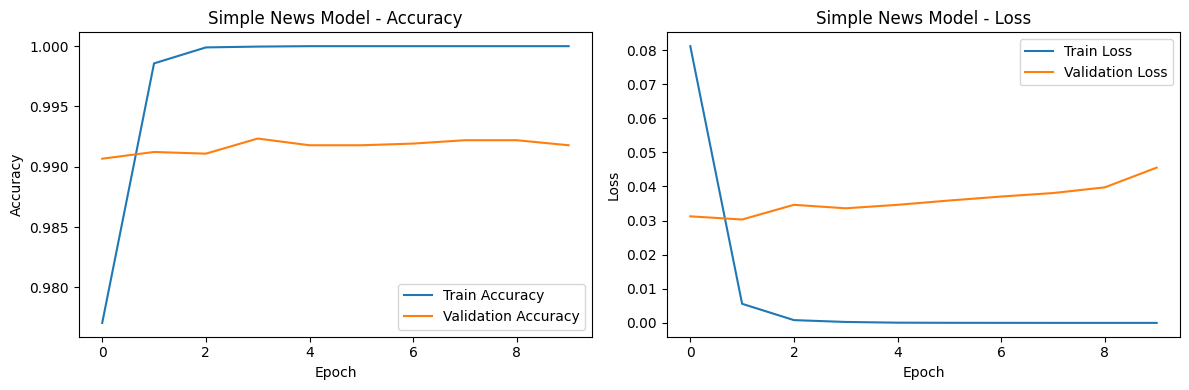

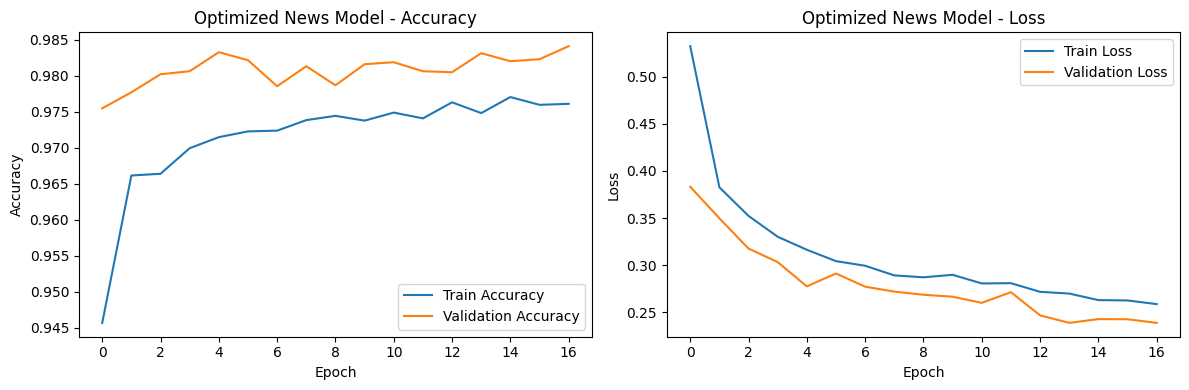

In [15]:
# Visualize the results
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(122)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(simple_history, 'Simple News Model')
plot_history(optimized_history, 'Optimized News Model')


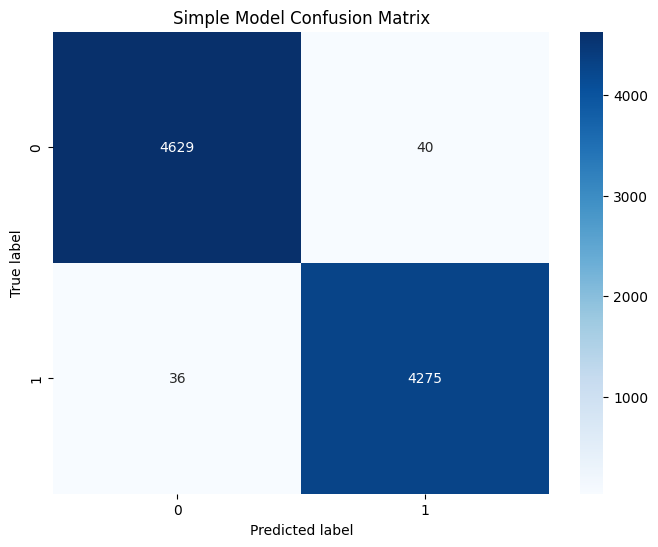

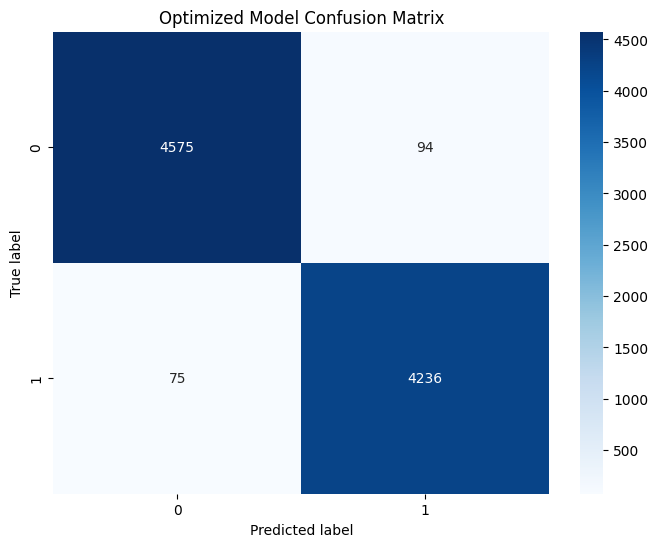

In [16]:
# Additional visualization: Confusion Matrix
# Plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(simple_cm, 'Simple Model Confusion Matrix')
plot_confusion_matrix(optimized_cm, 'Optimized Model Confusion Matrix')

In [17]:
# Print performance comparison
print("\nPerformance Comparison:")
print(f"Simple Model Accuracy: {simple_accuracy:.4f}")
print(f"Optimized Model Accuracy: {optimized_accuracy:.4f}")
print(f"Accuracy Improvement: {optimized_accuracy - simple_accuracy:.4f}")


Performance Comparison:
Simple Model Accuracy: 0.9915
Optimized Model Accuracy: 0.9812
Accuracy Improvement: -0.0104
